In [3]:
"""
20190130

@author: Ross.Lee

Ref: 
1. https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py
2.

paper: https://arxiv.org/abs/1711.04340
"""

'\n20190130\n\nRef: \n1. https://github.com/AntreasAntoniou/DAGAN\n2. https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py\n\npaper: https://arxiv.org/abs/1711.04340\n\n'

# Import

In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import load_model

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

import matplotlib.pyplot as plt

import numpy as np

Using TensorFlow backend.


# Simple DAGAN revised from CGAN

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
__________

FileNotFoundError: [Errno 2] No such file or directory: 'DACGAN_Images/0.png'

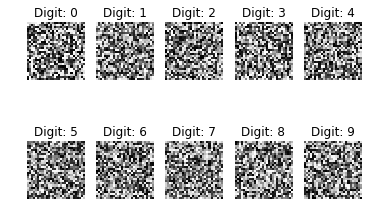

In [3]:
class CGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 100

        optimizer = Adam(0.0001, beta_1=0, beta_2=0.999)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid = self.discriminator([img, label])

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model([noise, label], valid)  # 讓generated的圖分數等於1
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        # Embed the num_classes as vectors and define the output shape as same as image shape
        # https://keras.io/layers/embeddings/
        # It's the mapping process same as encoder
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):
        """
        To discriminate between the samples from
            a. real distribution (other real images from the same class)
            b. fake distribution (images generated from the generator network)
        """

        model = Sequential()

        model.add(Dense(512, input_dim=np.prod(self.img_shape)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)  # other images from the same classes
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)

        # img's dim
        model_input = multiply([flat_img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Configure input
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs, labels = X_train[idx], y_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # Generate a half batch of new images
              # 要找同label的其他資料
            gen_imgs = self.generator.predict([noise, labels])

            other_imgs = np.empty(shape=(batch_size, *X_train.shape[1: ]))
            for i, label in enumerate(labels):
                new_idx_pool = np.delete(y_train, idx[i])
                other_idx = np.random.choice(np.where(new_idx_pool == label)[0])
                other_imgs[i] = X_train[other_idx]

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(
                [other_imgs, labels], valid)  # imgs changed to other_imgs
            d_loss_fake = self.discriminator.train_on_batch(
                [gen_imgs, labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Condition on labels
            sampled_labels = np.random.randint(
                0, 10, batch_size).reshape(-1, 1)

            # Train the generator
            g_loss = self.combined.train_on_batch(
                [noise, sampled_labels], valid)

            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
        
        return self.generator
    
    def sample_images(self, epoch):
        r, c = 2, 5  # row and column
        # same as GAN, input noise
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.arange(0, 10).reshape(-1, 1)  # sample label s

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig("DACGAN_Images/%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    cgan = CGAN()
    DACGAN_generator = cgan.train(epochs=10, batch_size=32, sample_interval=200)  # epoch先設少
    # DACGAN_generator.save("DACGAN_generator.h5")

# DAGAN revised from cWGAN-GP

Label Encoder:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5)                 0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         74881     
Total params: 74,881
Trainable params: 74,689
Non-trainable params: 192
_________________________________________________________________
Generator:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 5)         50          input_3[0][0]                    
___________

/home/rossleecooloh/.pyenv/versions/3.6.6/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 5.618153] [G loss: -0.368748]


FileNotFoundError: [Errno 2] No such file or directory: 'DAcWGANGP_Images/mnist_0.png'

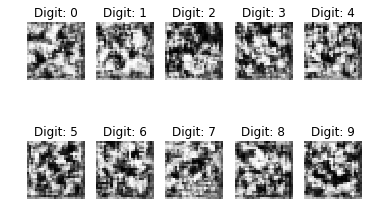

In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import concatenate
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
from functools import partial
import keras.backend as K
import matplotlib.pyplot as plt
import sys
import numpy as np


batch_size = 128

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples 

        Takes a randomly-weighted average of two tensors. In geometric terms, this outputs a random point on the line
        between each pair of input points.

        Inheriting from _Merge is a little messy but it was the quickest solution I could think of.
        Improvements appreciated."""

    def _merge_function(self, inputs):
        """兩個tensor的隨機權重平均"""
        # batch_size的所有維度都要有一個weight去進行平均
        # sample a random weight for convex average (for a batch of tensors)
        alpha = K.random_uniform((batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])


class DAcWGANGP():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10
        self.latent_dim = 256
        self.label_latent_dim = 5  # the transformed latent dim of label
        self.num_condition = 1
        # for critic input
        self.conditioned_img_shape = (
            self.img_rows, self.img_cols, self.channels + self.num_condition)
        # for generator input
        self.conditioned_latent_dim = self.latent_dim + self.label_latent_dim

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 3
        optimizer = Adam(lr=0.0001, beta_1=0, beta_2=0.9)  # as paper proposed

        # Build the generator and critic
        self.encoder = self.label_encoder()
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        print("Label Encoder:")
        self.encoder.summary()
        print("Generator:")
        self.generator.summary()
        print("Critic:")
        self.critic.summary()

        # -------------------------------
        # Construct Computational Graph
        #       for the Critic
        # -------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        z_disc = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        fake_img = self.generator([z_disc, label])

        # Discriminator determines validity of the real and fake images
        fake = self.critic([fake_img, label])
        valid = self.critic([real_img, label])
        print(real_img.shape)
        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic([interpolated_img, label])

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                                  averaged_samples=interpolated_img)
        # Functions need names or Keras will throw an error
        partial_gp_loss.__name__ = 'gradient_penalty'

        # 將G和D模型結合起來訓練D，輸入是真圖和noise；輸出為critic的真、假圖和penalty分數
        # real_img -> critic -> valid
        # fake_img -> critic -> fake
        # real_image & fake_image -> RandomWeightedAverage -> critic -> validity interpolation

        self.critic_model = Model(inputs=[real_img, z_disc, label],
                                  outputs=[valid, fake, validity_interpolated])

        self.critic_model.compile(loss=[self.wasserstein_loss,
                                        self.wasserstein_loss,
                                        partial_gp_loss],
                                  optimizer=optimizer,
                                  loss_weights=[1, 1, 10])
        # -------------------------------
        # Construct Computational Graph
        #         for Generator
        # -------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(self.latent_dim,))
        # Generate images based of noise
        img = self.generator([z_gen, label])
        # Discriminator determines validity
        valid = self.critic([img, label])
        # Defines generator model
        # 吃noise生結果並算loss => noise-G-D-loss
        self.generator_model = Model([z_gen, label], valid)
        self.generator_model.compile(
            loss=self.wasserstein_loss, optimizer=optimizer)  # G用W距離

    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        """Calculates the gradient penalty loss for a batch of "averaged" samples.
            In Improved WGANs, the 1-Lipschitz constraint is enforced by adding a term to the loss function
        that penalizes the network if the gradient norm moves away from 1. However, it is impossible to evaluate
        this function at all points in the input space. The compromise used in the paper is to choose random points
        on the lines between real and generated samples, and check the gradients at these points. Note that it is the
        gradient w.r.t. the input averaged samples, not the weights of the discriminator, that we're penalizing!
        In order to evaluate the gradients, we must first run samples through the generator and evaluate the loss.
        Then we get the gradients of the discriminator w.r.t. the input averaged samples.
        The l2 norm and penalty can then be calculated for this gradient.
        Note that this loss function requires the original averaged samples as input, but Keras only supports passing
        y_true and y_pred to loss functions. To get around this, we make a partial() of the function with the
        averaged_samples argument, and use that for model training."""
        # first get the gradients:
        #   assuming: - that y_pred has dimensions (batch_size, 1)
        #             - averaged_samples has dimensions (batch_size, nbr_features)
        # gradients afterwards has dimension (batch_size, nbr_features), basically
        # a list of nbr_features-dimensional gradient vectors
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def label_encoder(self):
        """
        To encode the label vector (Embedding) as the new image and therefore can be concatenated
            to the generative images by channels.
        """
        model = Sequential()

        model.add(Dense(7 * 7 * 64, activation="linear",
                        input_dim=self.label_latent_dim))
        model.add(Reshape((7, 7, 64)))  # reshape must be same
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding='same'))  # 14*14*filters
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(32, kernel_size=3, padding="same"))  # 28*28*filters
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3,
                         padding="same"))  # 28*28*channels
        model.add(Activation("tanh"))

        label = Input(shape=(self.label_latent_dim,))
        code = model(label)

        return Model(label, code)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu",
                        input_dim=self.conditioned_latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        # model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.label_latent_dim)(label))
        # conditioned noise with embedded label
        model_input = concatenate([noise, label_embedding])

        img = model(model_input)

        return Model([noise, label], img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2,
                         input_shape=self.conditioned_img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        # model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')
        label_flat = Flatten()(Embedding(self.num_classes, self.label_latent_dim)(label))

        label_embedding = self.encoder(label_flat)
        # conditioned generated imgs with transformed label (the size is as same as gen_imgs)
        model_input = concatenate([img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1))  # Dummy gt for gradient penalty

        for epoch in range(epochs):

            for _ in range(self.n_critic):
                
                
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs, labels = X_train[idx], y_train[idx]
                
                # find other images from the same class
                other_imgs = np.empty(shape=(batch_size, *X_train.shape[1: ]))
                cnt = 0
                while cnt < labels.shape[0]:
                    other_idx = np.random.choice(np.where(y_train == labels[cnt])[0])
                    if other_idx == idx[cnt]:
                        continue
                    else:
                        other_imgs[cnt] = X_train[other_idx]
                        cnt += 1
                
                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([other_imgs, noise, labels],   # imgs changed to other_imgs
                                                          [valid, fake, dummy])
                # The dummy vector is passed to the gradient_penalty loss function and is not used.

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.generator_model.train_on_batch(
                [noise, labels], valid)

            # Plot the progress
            print("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

        return self.generator

    def sample_images(self, epoch):
        r, c = 2, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        # define corresponding labels
        sampled_labels = np.arange(0, 10).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * (gen_imgs + 1)

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].set_title("Digit: %d" % sampled_labels[cnt])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig("DAcWGANGP_Images/mnist_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    DAcWGANGP = DAcWGANGP()
    generator = DAcWGANGP.train(
        epochs=10, batch_size=batch_size, sample_interval=100)  # 設少才不會開失敗
    # generator.save("DAcWGANGP_generator.h5")

## Load the trained model

In [2]:
generator = load_model("DAcWGANGP_generator.h5")

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Generated images visualization 

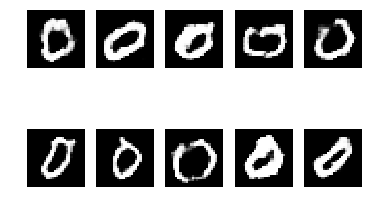

In [9]:
latent_dim = 256
num_imgs = 10
label = 0
noise = np.random.normal(0, 1, (num_imgs, latent_dim))
labels = np.repeat(label, num_imgs)
nrow = 2
ncol = 5

generated_imgs = generator.predict([noise, labels])
generated_imgs = 0.5 * (generated_imgs + 1)

fig, axs = plt.subplots(nrows=nrow, ncols=ncol)
cnt = 0
for r in range(nrow):
    for c in range(ncol):
        axs[r, c].imshow(generated_imgs[cnt, :, :, 0], cmap='gray')
        axs[r, c].axis('off')
        cnt += 1
plt.show()

# DAcWGAN-GP for Tiny MNIST dataset

In [4]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers import concatenate
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
from functools import partial
import keras.backend as K
import matplotlib.pyplot as plt
import sys
import numpy as np

batch_size = 128


class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples 

        Takes a randomly-weighted average of two tensors. In geometric terms, this outputs a random point on the line
        between each pair of input points.

        Inheriting from _Merge is a little messy but it was the quickest solution I could think of.
        Improvements appreciated."""

    def _merge_function(self, inputs):
        """兩個tensor的隨機權重平均"""
        # batch_size的所有維度都要有一個weight去進行平均
        # sample a random weight for convex average (for a batch of tensors)
        alpha = K.random_uniform((batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])


class DAcWGANGP():
    def __init__(self,
                 img_shape=(28, 28, 1),  # Height, Width, Channel
                 num_classes=10,
                 latent_dim=256,
                 label_latent_dim=5,
                 num_conditions=1,
                 n_critic=5,
                 optimizer= Adam(lr=0.0001, beta_1=0, beta_2=0.9),  # as paper proposed
                 fig_output_path="Tiny_MNIST_Images",
                 fig_rows=2,
                 fig_cols=5):

        self.img_shape = img_shape
        self.num_classes = num_classes
        self.latent_dim = latent_dim
        self.label_latent_dim = label_latent_dim  # the transformed latent dim of label
        self.num_condition = 1
        width, height, self.channels = img_shape
        self.cnn_w = width // 2**2
        self.cnn_h = height // 2**2
        # for critic input
        self.conditioned_img_shape = (width, height, self.channels + num_conditions)
        # for generator input
        self.conditioned_latent_dim = self.latent_dim + self.label_latent_dim
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = n_critic
        optimizer = optimizer
        self.fig_output_path = fig_output_path

        # Build the generator and critic
        self.encoder = self.label_encoder()
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        print("Label Encoder:")
        self.encoder.summary()
        print("Generator:")
        self.generator.summary()
        print("Critic:")
        self.critic.summary()

        # -------------------------------
        # Construct Computational Graph
        #       for the Critic
        # -------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        z_disc = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        fake_img = self.generator([z_disc, label])

        # Discriminator determines validity of the real and fake images
        fake = self.critic([fake_img, label])
        valid = self.critic([real_img, label])
        print(real_img.shape)
        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic([interpolated_img, label])

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                                  averaged_samples=interpolated_img)
        # Functions need names or Keras will throw an error
        partial_gp_loss.__name__ = 'gradient_penalty'

        # 將G和D模型結合起來訓練D，輸入是真圖和noise；輸出為critic的真、假圖和penalty分數
        # real_img -> critic -> valid
        # fake_img -> critic -> fake
        # real_image & fake_image -> RandomWeightedAverage -> critic -> validity interpolation

        self.critic_model = Model(inputs=[real_img, z_disc, label],
                                  outputs=[valid, fake, validity_interpolated])

        self.critic_model.compile(loss=[self.wasserstein_loss,
                                        self.wasserstein_loss,
                                        partial_gp_loss],
                                  optimizer=optimizer,
                                  loss_weights=[1, 1, 10])
        # -------------------------------
        # Construct Computational Graph
        #         for Generator
        # -------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(self.latent_dim,))
        # Generate images based of noise
        img = self.generator([z_gen, label])
        # Discriminator determines validity
        valid = self.critic([img, label])
        # Defines generator model
        # 吃noise生結果並算loss => noise-G-D-loss
        self.generator_model = Model([z_gen, label], valid)
        self.generator_model.compile(
            loss=self.wasserstein_loss, optimizer=optimizer)  # G用W距離

    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        """Calculates the gradient penalty loss for a batch of "averaged" samples.
            In Improved WGANs, the 1-Lipschitz constraint is enforced by adding a term to the loss function
        that penalizes the network if the gradient norm moves away from 1. However, it is impossible to evaluate
        this function at all points in the input space. The compromise used in the paper is to choose random points
        on the lines between real and generated samples, and check the gradients at these points. Note that it is the
        gradient w.r.t. the input averaged samples, not the weights of the discriminator, that we're penalizing!
        In order to evaluate the gradients, we must first run samples through the generator and evaluate the loss.
        Then we get the gradients of the discriminator w.r.t. the input averaged samples.
        The l2 norm and penalty can then be calculated for this gradient.
        Note that this loss function requires the original averaged samples as input, but Keras only supports passing
        y_true and y_pred to loss functions. To get around this, we make a partial() of the function with the
        averaged_samples argument, and use that for model training."""
        # first get the gradients:
        #   assuming: - that y_pred has dimensions (batch_size, 1)
        #             - averaged_samples has dimensions (batch_size, nbr_features)
        # gradients afterwards has dimension (batch_size, nbr_features), basically
        # a list of nbr_features-dimensional gradient vectors
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def label_encoder(self):
        """
        To encode the label vector (Embedding) as the new image and therefore can be concatenated
            to the generative images by channels.
        """
        model = Sequential()
        
        model.add(Dense(self.cnn_w * self.cnn_h * 64, activation="linear",
                        input_dim=self.label_latent_dim))
        model.add(Reshape((self.cnn_w, self.cnn_h, 64)))  # reshape must be same
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding='same'))  # 14*14*filters
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(32, kernel_size=3, padding="same"))  # 28*28*filters
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3,
                         padding="same"))  # 28*28*channels
        model.add(Activation("tanh"))

        label = Input(shape=(self.label_latent_dim,))
        code = model(label)

        return Model(label, code)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * self.cnn_w * self.cnn_h, activation="relu",
                        input_dim=self.conditioned_latent_dim))
        model.add(Reshape((self.cnn_w, self.cnn_h, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        # model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        # Embedding -> None, 1, 5 -> Flatten -> None, 5
        label_embedding = Flatten()(Embedding(self.num_classes, self.label_latent_dim)(label))
        # conditioned noise with embedded label
        model_input = concatenate([noise, label_embedding])

        img = model(model_input)

        return Model([noise, label], img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2,
                         input_shape=self.conditioned_img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        # model.summary()

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')
        label_flat = Flatten()(Embedding(self.num_classes, self.label_latent_dim)(label))

        label_embedding = self.encoder(label_flat)
        # conditioned generated imgs with transformed label (the size is as same as gen_imgs)
        model_input = concatenate([img, label_embedding])

        validity = model(model_input)

        return Model([img, label], validity)

    def train(self, epochs, batch_size, sample_interval=50, X_train=None, y_train=None):

        # Load the dataset
        # (X_train, y_train), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))
        dummy = np.zeros((batch_size, 1))  # Dummy gt for gradient penalty

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs, labels = X_train[idx], y_train[idx]

                # find other images from the same class
                other_imgs = np.empty(shape=(batch_size, *X_train.shape[1:]))
                cnt = 0  # 第幾張圖
                while cnt < labels.shape[0]:
                    other_idx = np.random.choice(
                        np.where(y_train == labels[cnt])[0])
                    if other_idx == idx[cnt]:
                        continue
                    else:
                        other_imgs[cnt] = X_train[other_idx]
                        cnt += 1

                # Sample generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([other_imgs, noise, labels],   # imgs changed to other_imgs
                                                          [valid, fake, dummy])
                # The dummy vector is passed to the gradient_penalty loss function and is not used.

            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.generator_model.train_on_batch(
                [noise, labels], valid)

            # Plot the progress
            print("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

        return self.generator

    def sample_images(self, epoch):
        fig_rows, fig_cols = 2, 5
        noise = np.random.normal(0, 1, (fig_rows * fig_cols, self.latent_dim))
        # define corresponding labels
        sampled_labels = np.arange(0, self.num_classes).reshape(-1, 1)

        gen_imgs = self.generator.predict([noise, sampled_labels])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * (gen_imgs + 1)

        fig, axs = plt.subplots(fig_rows, fig_cols)
        cnt = 0
        for i in range(fig_rows):
            for j in range(fig_cols):
                if self.channels == 1:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                else:
                    axs[i, j].imshow(gen_imgs[cnt, :, :, 0])
                axs[i, j].set_title("Label: %d" % sampled_labels[cnt])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(f"{self.fig_output_path}/gen_{epoch}.jpg")
        plt.close()


# if __name__ == '__main__':
#     DAcWGANGP = DAcWGANGP()
#     generator = DAcWGANGP.train(
#         epochs=20000, batch_size=batch_size, sample_interval=100)
#     generator.save("DAcWGANGP_generator.h5")

## Start Training

Label Encoder:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 5)                 0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 28, 28, 1)         74881     
Total params: 74,881
Trainable params: 74,689
Non-trainable params: 192
_________________________________________________________________
Generator:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 5)         50          input_27[0][0]                   
___________

FileNotFoundError: [Errno 2] No such file or directory: 'Tiny_MNIST_Images/gen_0.jpg'

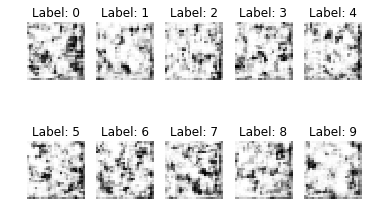

In [6]:
TinyMNIST = DAcWGANGP()

(X_train, y_train), (_, _) = mnist.load_data()

num_samples = 25
num_classes = 10
exist = True

for i in range(num_classes):
    labels_idx = np.where(y_train == i)[0]
    idices = np.random.choice(labels_idx, size=num_samples)
    if exist:
        X_train_tiny = X_train[idices]
        exist = False
    else:
        X_train_tiny = np.vstack((X_train_tiny, X_train[idices]))

y_train_tiny = np.repeat(range(num_classes), num_samples)

generator = TinyMNIST.train(epochs=20,
                            batch_size=128,
                            sample_interval=50,
                            X_train=X_train_tiny,
                            y_train=y_train_tiny)

# generator.save("TinyMNISTgenerator.h5")


## Load model

In [3]:
generator = load_model("TinyMNISTgenerator.h5")

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Generated images visualization 

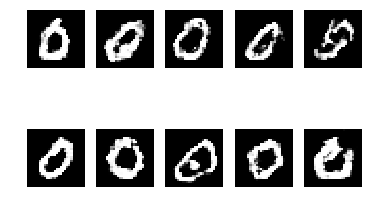

In [8]:
latent_dim = 256
num_imgs = 10
label = 0
noise = np.random.normal(0, 1, (num_imgs, latent_dim))
labels = np.repeat(label, num_imgs)
nrow = 2
ncol = 5

generated_imgs = generator.predict([noise, labels])
generated_imgs = 0.5 * (generated_imgs + 1)

fig, axs = plt.subplots(nrows=nrow, ncols=ncol)
cnt = 0
for r in range(nrow):
    for c in range(ncol):
        axs[r, c].imshow(generated_imgs[cnt, :, :, 0], cmap='gray')
        axs[r, c].axis('off')
        cnt += 1
plt.show()


# Other resource

In [ ]:
"""
https://github.com/AntreasAntoniou/DAGAN
"""

## check the architecture of the NN (for TensorFlow)

In [3]:
import numpy as np

from tensorflow.python.layers import base
import tensorflow as tf
import tensorflow.contrib.slim as slim

x = np.zeros((1,4,4,3))
x_tf = tf.convert_to_tensor(x, np.float32)
z_tf = tf.layers.conv2d(x_tf, filters=32, kernel_size=(3,3))

def model_summary():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)

model_summary()

'\nx = np.zeros((1,4,4,3))\nx_tf = tf.convert_to_tensor(x, np.float32)\nz_tf = tf.layers.conv2d(x_tf, filters=32, kernel_size=(3,3))\n'

## UResNet Generator

In [ ]:
class UResNetGenerator:
    def __init__(self, layer_sizes, layer_padding, batch_size, num_channels=1,
                 inner_layers=0, name="g"):
        """
        Initialize a UResNet generator.
        :param layer_sizes: A list with the filter sizes for each MultiLayer e.g. [64, 64, 128, 128]
        :param layer_padding: A list with the padding type for each layer e.g. ["SAME", "SAME", "SAME", "SAME"]
        :param batch_size: An integer indicating the batch size
        :param num_channels: An integer indicating the number of input channels
        :param inner_layers: An integer indicating the number of inner layers per MultiLayer
        """
        self.reuse = False
        self.batch_size = batch_size
        self.num_channels = num_channels
        self.layer_sizes = layer_sizes
        self.layer_padding = layer_padding
        self.inner_layers = inner_layers
        self.conv_layer_num = 0
        self.build = True
        self.name = name

    def upscale(self, x, h_size, w_size):
        """
        Upscales an image using nearest neighbour
        :param x: Input image
        :param h_size: Image height size
        :param w_size: Image width size
        :return: Upscaled image
        """
        [b, h, w, c] = [int(dim) for dim in x.get_shape()]

        return tf.image.resize_nearest_neighbor(x, (h_size, w_size))

    def conv_layer(self, inputs, num_filters, filter_size, strides, activation=None,
                   transpose=False, w_size=None, h_size=None):
        """
        Add a convolutional layer to the network.
        :param inputs: Inputs to the conv layer.
        :param num_filters: Num of filters for conv layer.
        :param filter_size: Size of filter.
        :param strides: Stride size.
        :param activation: Conv layer activation.
        :param transpose: Whether to apply upscale before convolution.
        :param w_size: Used only for upscale, w_size to scale to.
        :param h_size: Used only for upscale, h_size to scale to.
        :return: Convolution features
        """
        self.conv_layer_num += 1
        if transpose:
            outputs = self.upscale(inputs, h_size=h_size, w_size=w_size)
            outputs = tf.layers.conv2d_transpose(outputs, num_filters, filter_size,
                                                 strides=strides,
                                       padding="SAME", activation=activation)
        elif not transpose:
            outputs = tf.layers.conv2d(inputs, num_filters, filter_size, strides=strides,
                                                 padding="SAME", activation=activation)
        return outputs

    def resize_batch(self, batch_images, size):

        """
        Resize image batch using nearest neighbour
        :param batch_images: Image batch
        :param size: Size to upscale to
        :return: Resized image batch.
        """
        images = tf.image.resize_images(batch_images, size=size, method=ResizeMethod.NEAREST_NEIGHBOR)

        return images

    def add_encoder_layer(self, input, name, training, dropout_rate, layer_to_skip_connect, local_inner_layers,
                          num_features, dim_reduce=False):

        """
        Adds a resnet encoder layer.
        :param input: The input to the encoder layer
        :param training: Flag for training or validation
        :param dropout_rate: A float or a placeholder for the dropout rate
        :param layer_to_skip_connect: Layer to skip-connect this layer to
        :param local_inner_layers: A list with the inner layers of the current Multi-Layer
        :param num_features: Number of feature maps for the convolutions
        :param dim_reduce: Boolean value indicating if this is a dimensionality reducing layer or not
        :return: The output of the encoder layer
        """
        [b1, h1, w1, d1] = input.get_shape().as_list()

        if len(layer_to_skip_connect) >= 2:
            layer_to_skip_connect = layer_to_skip_connect[-2]
        else:
            layer_to_skip_connect = None

        if layer_to_skip_connect is not None:
            [b0, h0, w0, d0] = layer_to_skip_connect.get_shape().as_list()
            if h0 > h1:
                skip_connect_layer = self.conv_layer(layer_to_skip_connect, int(layer_to_skip_connect.get_shape()[3]),
                                                     [3, 3], strides=(2, 2))
            else:
                skip_connect_layer = layer_to_skip_connect
            current_layers = [input, skip_connect_layer]
        else:
            current_layers = [input]

        current_layers.extend(local_inner_layers)
        current_layers = remove_duplicates(current_layers)
        outputs = tf.concat(current_layers, axis=3)

        if dim_reduce:
            outputs = self.conv_layer(outputs, num_features, [3, 3], strides=(2, 2))
            outputs = leaky_relu(outputs)
            outputs = batch_norm(outputs, decay=0.99, scale=True,
                                 center=True, is_training=training,
                                 renorm=True)
            outputs = tf.layers.dropout(outputs, rate=dropout_rate, training=training)
        else:
            outputs = self.conv_layer(outputs, num_features, [3, 3], strides=(1, 1))
            outputs = leaky_relu(features=outputs)
            outputs = batch_norm(outputs, decay=0.99, scale=True,
                                 center=True, is_training=training,
                                 renorm=True)

        return outputs

    def add_decoder_layer(self, input, name, training, dropout_rate, layer_to_skip_connect, local_inner_layers,
                          num_features, dim_upscale=False, h_size=None, w_size=None):

        """
        Adds a resnet decoder layer.
        :param input: Input features
        :param name: Layer Name
        :param training: Training placeholder or boolean flag
        :param dropout_rate: Float placeholder or float indicating the dropout rate
        :param layer_to_skip_connect: Layer to skip connect to.
        :param local_inner_layers: A list with the inner layers of the current MultiLayer
        :param num_features: Num feature maps for convolution
        :param dim_upscale: Dimensionality upscale
        :param h_size: Height to upscale to
        :param w_size: Width to upscale to
        :return: The output of the decoder layer
        """
        [b1, h1, w1, d1] = input.get_shape().as_list()
        if len(layer_to_skip_connect) >= 2:
            layer_to_skip_connect = layer_to_skip_connect[-2]
        else:
            layer_to_skip_connect = None

        if layer_to_skip_connect is not None:
            [b0, h0, w0, d0] = layer_to_skip_connect.get_shape().as_list()

            if h0 < h1:
                skip_connect_layer = self.conv_layer(layer_to_skip_connect,
                                                     int(layer_to_skip_connect.get_shape()[3]),
                                                     [3, 3], strides=(1, 1),
                                                     transpose=True,
                                                     h_size=h_size,
                                                     w_size=w_size)
            else:
                skip_connect_layer = layer_to_skip_connect
            current_layers = [input, skip_connect_layer]
        else:
            current_layers = [input]

        current_layers.extend(local_inner_layers)
        current_layers = remove_duplicates(current_layers)
        outputs = tf.concat(current_layers, axis=3)

        if dim_upscale:
            outputs = self.conv_layer(outputs, num_features, [3, 3], strides=(1, 1),
                                      transpose=True, w_size=w_size, h_size=h_size)
            outputs = leaky_relu(features=outputs)
            outputs = batch_norm(outputs,
                                 decay=0.99, scale=True,
                                 center=True, is_training=training,
                                 renorm=True)
            outputs = tf.layers.dropout(outputs, rate=dropout_rate, training=training)
        else:
            outputs = self.conv_layer(outputs, num_features, [3, 3], strides=(1, 1),
                                       transpose=False)
            outputs = leaky_relu(features=outputs)
            outputs = batch_norm(outputs, decay=0.99, scale=True,
                                 center=True, is_training=training,
                                 renorm=True)

        return outputs

    def __call__(self, z_inputs, conditional_input, training=False, dropout_rate=0.0):
        """
        Apply network on data.
        :param z_inputs: Random noise to inject [batch_size, z_dim]
        :param conditional_input: A batch of images to use as conditionals [batch_size, height, width, channels]
        :param training: Training placeholder or boolean
        :param dropout_rate: Dropout rate placeholder or float
        :return: Returns x_g (generated images), encoder_layers(encoder features), decoder_layers(decoder features)
        """
        conditional_input = tf.convert_to_tensor(conditional_input)
        with tf.variable_scope(self.name, reuse=self.reuse):
            # reshape from inputs
            outputs = conditional_input
            encoder_layers = []
            current_layers = [outputs]
            with tf.variable_scope('conv_layers'):

                for i, layer_size in enumerate(self.layer_sizes):
                    encoder_inner_layers = [outputs]
                    with tf.variable_scope('g_conv{}'.format(i)):
                        if i==0: #first layer is a single conv layer instead of MultiLayer for best results
                            outputs = self.conv_layer(outputs, num_filters=64,
                                                      filter_size=(3, 3), strides=(2, 2))
                            outputs = leaky_relu(features=outputs)
                            outputs = batch_norm(outputs, decay=0.99, scale=True,
                                                 center=True, is_training=training,
                                                 renorm=True)
                            current_layers.append(outputs)
                            encoder_inner_layers.append(outputs)
                        else:
                            for j in range(self.inner_layers[i]): #Build the inner Layers of the MultiLayer
                                outputs = self.add_encoder_layer(input=outputs,
                                                                 training=training,
                                                                 name="encoder_layer_{}_{}".format(i, j),
                                                                 layer_to_skip_connect=current_layers,
                                                                 num_features=self.layer_sizes[i],
                                                                 dim_reduce=False,
                                                                 local_inner_layers=encoder_inner_layers,
                                                                 dropout_rate=dropout_rate)
                                encoder_inner_layers.append(outputs)
                                current_layers.append(outputs)
                            #add final dim reducing conv layer for this MultiLayer
                            outputs = self.add_encoder_layer(input=outputs, name="encoder_layer_{}".format(i),
                                                             training=training, layer_to_skip_connect=current_layers,
                                                             local_inner_layers=encoder_inner_layers,
                                                             num_features=self.layer_sizes[i],
                                                             dim_reduce=True, dropout_rate=dropout_rate)
                            current_layers.append(outputs)
                        encoder_layers.append(outputs)

            g_conv_encoder = outputs

            with tf.variable_scope("vector_expansion"):  # Used for expanding the z injected noise to match the
                                                         # dimensionality of the various decoder MultiLayers, injecting
                                                         # noise into multiple decoder layers in a skip-connection way
                                                         # improves quality of results. We inject in the first 3 decode
                                                         # multi layers
                num_filters = 8
                z_layers = []
                concat_shape = [layer_shape.get_shape().as_list() for layer_shape in encoder_layers]

                for i in range(len(self.inner_layers)):
                    h = concat_shape[len(encoder_layers) - 1 - i][1]
                    w = concat_shape[len(encoder_layers) - 1 - i][1]
                    z_dense = tf.layers.dense(z_inputs, h * w * num_filters)
                    z_reshape_noise = tf.reshape(z_dense, [self.batch_size, h, w, num_filters])
                    num_filters /= 2
                    num_filters = int(num_filters)
                    print(z_reshape_noise)
                    z_layers.append(z_reshape_noise)

            outputs = g_conv_encoder
            decoder_layers = []
            current_layers = [outputs]
            with tf.variable_scope('g_deconv_layers'):
                for i in range(len(self.layer_sizes)+1):
                    if i<3: #Pass the injected noise to the first 3 decoder layers for sharper results
                        outputs = tf.concat([z_layers[i], outputs], axis=3)
                        current_layers[-1] = outputs
                    idx = len(self.layer_sizes) - 1 - i
                    num_features = self.layer_sizes[idx]
                    inner_layers = self.inner_layers[idx]
                    upscale_shape = encoder_layers[idx].get_shape().as_list()
                    if idx<0:
                        num_features = self.layer_sizes[0]
                        inner_layers = self.inner_layers[0]
                        outputs = tf.concat([outputs, conditional_input], axis=3)
                        upscale_shape = conditional_input.get_shape().as_list()

                    with tf.variable_scope('g_deconv{}'.format(i)):
                        decoder_inner_layers = [outputs]
                        for j in range(inner_layers):
                            if i==0 and j==0:
                                outputs = self.add_decoder_layer(input=outputs,
                                                                 name="decoder_inner_conv_{}_{}"
                                                                 .format(i, j),
                                                                 training=training,
                                                                 layer_to_skip_connect=current_layers,
                                                                 num_features=num_features,
                                                                 dim_upscale=False,
                                                                 local_inner_layers=decoder_inner_layers,
                                                                 dropout_rate=dropout_rate)
                                decoder_inner_layers.append(outputs)
                            else:
                                outputs = self.add_decoder_layer(input=outputs,
                                                                 name="decoder_inner_conv_{}_{}"
                                                                 .format(i, j), training=training,
                                                                 layer_to_skip_connect=current_layers,
                                                                 num_features=num_features,
                                                                 dim_upscale=False,
                                                                 local_inner_layers=decoder_inner_layers,
                                                                 w_size=upscale_shape[1],
                                                                 h_size=upscale_shape[2],
                                                                 dropout_rate=dropout_rate)
                                decoder_inner_layers.append(outputs)
                        current_layers.append(outputs)
                        decoder_layers.append(outputs)

                        if idx>=0:
                            upscale_shape = encoder_layers[idx - 1].get_shape().as_list()
                            if idx == 0:
                                upscale_shape = conditional_input.get_shape().as_list()
                            outputs = self.add_decoder_layer(
                                input=outputs,
                                name="decoder_outer_conv_{}".format(i),
                                training=training,
                                layer_to_skip_connect=current_layers,
                                num_features=num_features,
                                dim_upscale=True, local_inner_layers=decoder_inner_layers, w_size=upscale_shape[1],
                                h_size=upscale_shape[2], dropout_rate=dropout_rate)
                            current_layers.append(outputs)
                        if (idx-1)>=0:
                            outputs = tf.concat([outputs, encoder_layers[idx-1]], axis=3)
                            current_layers[-1] = outputs

                high_res_layers = []

                for p in range(2):
                    outputs = self.conv_layer(outputs, self.layer_sizes[0], [3, 3], strides=(1, 1),
                                                         transpose=False)
                    outputs = leaky_relu(features=outputs)

                    outputs = batch_norm(outputs,
                                         decay=0.99, scale=True,
                                         center=True, is_training=training,
                                         renorm=True)
                    high_res_layers.append(outputs)
                outputs = self.conv_layer(outputs, self.num_channels, [3, 3], strides=(1, 1),
                                                     transpose=False)
            # output images
            with tf.variable_scope('g_tanh'):
                gan_decoder = tf.tanh(outputs, name='outputs')

        self.reuse = True
        self.variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=self.name)

        if self.build:
            print("generator_total_layers", self.conv_layer_num)
            count_parameters(self.variables, name="generator_parameter_num")
        self.build = False
        return gan_decoder, encoder_layers, decoder_layers

In [ ]:
class OmniglotImbalancedDAGANDataset(DAGANImbalancedDataset):
    def __init__(self, batch_size, gan_training_index, reverse_channels, num_of_gpus, gen_batches):
        super(OmniglotImbalancedDAGANDataset, self).__init__(batch_size, gan_training_index, reverse_channels,
                                                            num_of_gpus, gen_batches)

    def load_dataset(self, gan_training_index):

        x = np.load("datasets/omniglot_data.npy")
        x_temp = []
        for i in range(x.shape[0]):
            choose_samples = np.random.choice([i for i in range(1, 15)])
            x_temp.append(x[i, :choose_samples])
        self.x = np.array(x_temp)
        x_train, x_test, x_val = self.x[:1200], self.x[1200:1600], self.x[1600:]
        x_train = x_train[:gan_training_index]

        return x_train, x_test, x_val